# Use AWS S3 to access GOES-16/17 data

With the increased temporal and spatial resolution of our geostationary satellite data with the launches of GOES 16 and 17, satellite data is becoming big data! To better handle this dataset, it is now available on AWS via NOAA. This notebook shows how to download GOES data and display it using the CartoPy package.

In [1]:
from datetime import datetime, timedelta
import itertools
from tempfile import NamedTemporaryFile

import boto3
import botocore
from botocore.client import Config
from netCDF4 import Dataset

In [2]:
#Create class to download data from S3
class GOESArchiveDownloader(object):
    def __init__(self):
        s3 = boto3.resource('s3', config=Config(signature_version=botocore.UNSIGNED, user_agent_extra='Resource'))
        self._bucket = s3.Bucket('noaa-goes16')

    def _get_iter(self, start, product):
        prod_prefix = str(product)
        start_marker = product.with_start_time(start)
        print(prod_prefix, start_marker)
        return self._bucket.objects.filter(Marker=start_marker, Prefix=str(product))
        
    def get_next(self, time, product):
        return next(iter(self._get_iter(time, product)))

    def get_range(self, start, end, product):
        end_key = product.with_start_time(end)

        # Get a list of files that have the proper prefix up to the hour
        return list(itertools.takewhile(lambda obj: obj.key <= end_key, self._get_iter(start, product)))

In [3]:
#Create class to choose the satellite product to display
class GOESProduct(object):
    def __init__(self, **kwargs):
        self.sector = 'conus'
        self.satellite = 'goes16'
        self.typ = 'ABI'
        self.channel = 1
        self.mode = 3
        self.datetime = datetime.utcnow()
        self.__dict__.update(kwargs)

    def __str__(self):
        env = 'OR'
        sat = {'goes16': 'G16', 'goes17': 'G17'}[self.satellite]

        if self.typ == 'ABI':
            sector = {'conus': 'C', 'meso1': 'M1', 'meso2': 'M2', 'full': 'F'}[self.sector]
            short_id = 'ABI-L1b-Rad{sector}'.format(sector=sector)
            prod_id = short_id + '-M{mode}C{channel:02d}'.format(mode=self.mode, channel=self.channel)
        elif self.typ == 'GLM':
            short_id = prod_id = 'GLM-L2-LCFA'
        else:
            raise ValueError('Unhandled data type: {}'.format(self.typ))
        return '{short_id}/{datetime:%Y/%j/%H}/{env}_{prodid}_{sat}'.format(short_id=short_id, datetime=self.datetime,
                                                                   env=env, prodid=prod_id, sat=sat)

    __repr__ = __str__

    def with_start_time(self, time):
        return str(self) + '_s{time:%Y%j%H%M%S}'.format(time=time)

In [4]:
# Functino to convert the data to netCDF format for easy viewing
def netcdf_from_s3(s3obj):
    # Download the data and open (in memory) with netCDF
    with NamedTemporaryFile(suffix='.nc') as temp:
        # Create a temporary netCDF file to work around bug in netCDF C 4.4.1.1
        # We shouldn't actually need any file on disk.
        nc_temp = Dataset(temp.name, 'w').close()
        return Dataset(temp.name, memory=s3obj.get()['Body'].read())

In [5]:
arc = GOESArchiveDownloader()

In [15]:
#Specify the time you want here as (year, month, day, hour, minute, second)
dt = datetime(2018, 10, 10, 19, 0, 0)
#If you want a GOES product other than the visible red channel, change the channel number below
obj = arc.get_next(dt, GOESProduct(typ='ABI', channel=2, sector='conus', datetime=dt))

ABI-L1b-RadC/2018/283/19/OR_ABI-L1b-RadC-M3C02_G16 ABI-L1b-RadC/2018/283/19/OR_ABI-L1b-RadC-M3C02_G16_s2018283190000


In [16]:
#Convert data to a netCDF file for visualization
nc = netcdf_from_s3(obj)

<IPython.core.display.Javascript object>


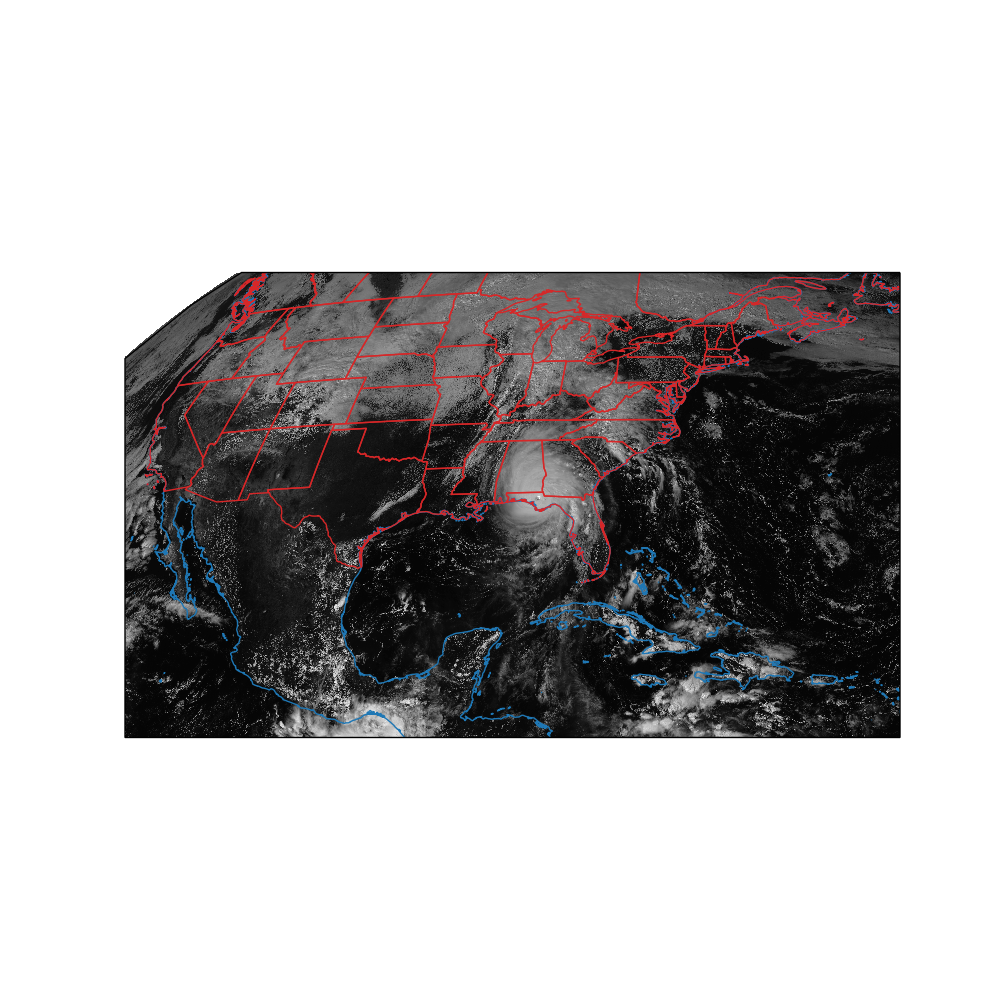

In [17]:
# Let's plot some data!
%matplotlib notebook

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

data = nc.variables['Rad'][:]
state_boundaries = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lakes',
                                                scale='50m', facecolor='none')

fig = plt.figure(figsize=(10,10))
proj_var = nc.variables['goes_imager_projection']
globe = ccrs.Globe(semimajor_axis=proj_var.semi_major_axis, semiminor_axis=proj_var.semi_minor_axis)
proj = ccrs.Geostationary(central_longitude=proj_var.longitude_of_projection_origin,
                          satellite_height=proj_var.perspective_point_height, globe=globe)
ax = fig.add_subplot(1, 1, 1, projection=proj)

x = nc.variables['x'][:] * proj_var.perspective_point_height
y = nc.variables['y'][:] * proj_var.perspective_point_height
ax.imshow(data, extent=(x.min(), x.max(), y.min(), y.max()), cmap='Greys_r', origin='upper')
ax.coastlines('10m', color='tab:blue')
ax.add_feature(state_boundaries, edgecolor='tab:red')
plt.show()